In [1]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Import your modules
#---------------------------------------
import admin_functions as adfn
import criticality as crfn
import IS as isfn
import trace_analyse as tfn

# Define paths
#----------------------------------------------------------------------
Fcode = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
Fdata = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
Fdoc = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
F10t2 = '/Volumes/Dominic 10tb2/'
Ftm = '/Volumes/Dominic Time Machine/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'

%load_ext autoreload
sys.version

'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

# Process data

In [4]:
#Find range to make bin over for correlation function
coord_l = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*regcoord*')

In [133]:
from sklearn.metrics.pairwise import euclidean_distances

#Find range to make bin over for correlation function
mini = 0
maxi = 0
dim = [.8, .8, 15]

for c in coord_l:
    coord = np.load(c)
    dist = euclidean_distances(coord)
    curr_max = np.max(dist)
    if maxi < curr_max:
        maxi = curr_max
print(maxi)

655.138672844927


In [334]:
#Calculate criticality statistics
trace_l = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*regtrace*')[:10]
dff_l = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*regdelt*')[:10]
bind_l = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*regbin*56*')[:10]
coord_l = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*labcoor*')[:10]
len(trace_l), len(dff_l), len(bind_l), len(coord_l)

(10, 10, 10, 10)

In [26]:
#Find mean nnb in previous work
prac = adfn.return_files(Fdata, 'PTZ-WILDTYPE', '*cutrealtrace*')
nnb_list = []
for i in range(len(prac)):
    nnb_list = np.append(nnb_list, np.load(prac[i]).shape[0]*(0.16/100))
print('mean neighbours = ' + str(np.mean(nnb_list)))

mean neighbours = 14.12128


In [ ]:
n_neigh = 14 #14
n_bins = 200 #Number of bins for correlation function
reg_list = ['all', 'Telencephalon', 'Diencephalon', 'Midbrain', 'Hindbrain']

for i in range(len(trace_l)):
    trace = np.load(trace_l[i])
    dff = np.load(dff_l[i])
    bind = np.load(bind_l[i])
    coord = (np.load(coord_l[i]))
    name = adfn.save_name(trace_l[i])

    for reg in reg_list:
        sub_trace, sub_dff, sub_bind, sub_coord = tfn.select_region(trace, dff, bind, coord, reg)
        data = tfn.trace_analyse(name, sub_trace, sub_dff, sub_bind, sub_coord) #Initiate class
        
        #Criticality statistics
        crit = data.criticality_stats(n_neigh, n_bins, mini, maxi) 
        par_list = ['av', 'llr_s', 'llr_d', 'exp_s', 'exp_d', 'dcc', 'br', 'corrdis']
        dic = {}
        dic.update({par: data.__dict__[par] for par in par_list})
        np.save(Fdata + 'BLNDEV-WILDTYPE/' + name + '_' + reg + '_criticality.npy', dic)
        
        #Firing statistics
        f_stats = data.firing_stats(30, 50) 
        par_list = ['fr', 'fa', 'fd', 's_corr', 'l_corr', 'dim']
        dic = {}
        dic.update({par: data.__dict__[par] for par in par_list})
        np.save(Fdata + 'BLNDEV-WILDTYPE/' + name + '_' + reg + '_firing.npy', dic)
        
        
    print('Processed ' + name)

# Whole brain

In [98]:
d3 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*3dpf*all*crit*')
d4 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*4dpf*all*crit*')
d5 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*5dpf*all*crit*')
d6 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*6dpf*all*crit*')
d7 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*7dpf*all*crit*')
d8 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*8dpf*all*crit*')
data_ll = d3, d4, d5, d6, d7, d8


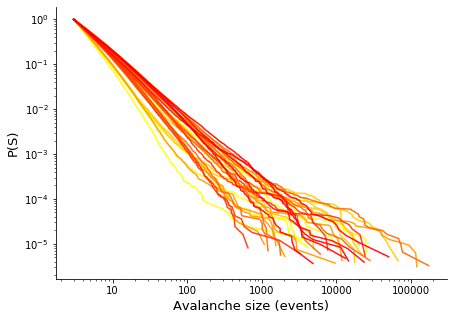

In [20]:
import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.autumn_r(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        avdistcut = data['av'][choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 0.9, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

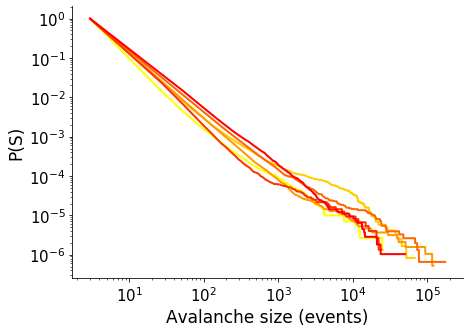

In [12]:
colors  = cm.autumn_r(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    yaxis, xaxis = crfn.mean_av(data_ll[i], 1000, 'size')
    hist = plt.plot(yaxis, xaxis, c = colors[i], linewidth = 2)

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

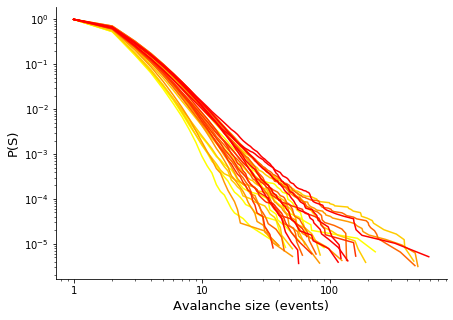

In [22]:
import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.autumn_r(np.linspace(0,1,len(data_ll)))
choose=1
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        avdistcut = data['av'][choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

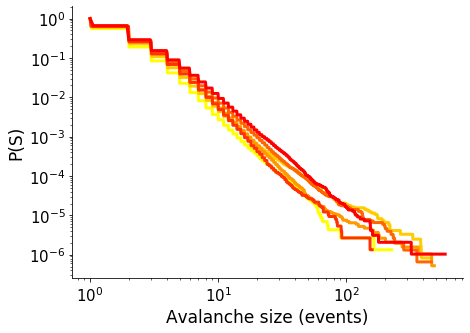

In [15]:
colors  = cm.autumn_r(np.linspace(0,1,len(data_ll)))
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    yaxis, xaxis = crfn.mean_av(data_ll[i], 10000, 'dur')
    hist = plt.plot(yaxis, xaxis, c = colors[i], linewidth = 3)

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

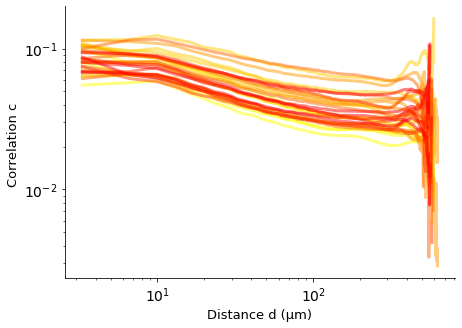

In [18]:
import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.autumn_r(np.linspace(0,1,len(data_ll)))
choose=1
fig, axarr = plt.subplots(figsize = (7,5))


for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        yaxis,xaxis = data['corrdis']
        axarr.plot(yaxis,xaxis, '-', linewidth = 3, alpha =0.5, color = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_xlabel('Distance d (μm)', size = '13')
axarr.set_ylabel('Correlation c ', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

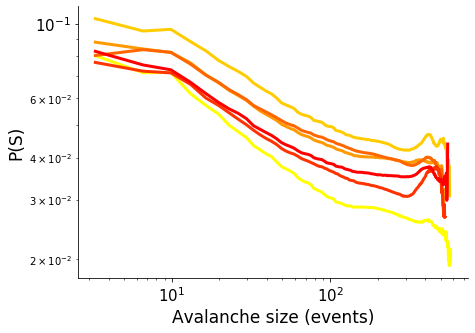

In [19]:
colors  = cm.autumn_r(np.linspace(0,1,len(data_ll)))
fig, axarr = plt.subplots(figsize = (7,5))

for e in range(len(data_ll)):
    
    data_l = data_ll[e]
    mean_y, mean_x = np.mean(np.asarray([np.load(data_l[i], allow_pickle=True).item()['corrdis'] for i in range(len(data_l))]), axis=0)
    yaxis,yaxis = data['corrdis']
    axarr.plot(mean_y,mean_x, '-', linewidth = 3, alpha = 1, color = colors[e])

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

In [36]:
#This function extracts each data type
def load(data_list, name_list):

    obj = { i:[[]]*len(data_list) for i in name_list  }

    for i in range(len(data_list)):
        for e in range(len(data_list[i])):
            data = np.load(data_list[i][e], allow_pickle=True).item()
            for name in name_list:
                curr = data[name]
                obj[name][i] = np.append(obj[name][i], curr)

        print(i)
        
    len_list = []
    for i in range(len(data_list)):
        count = 0
        for e in range(len(data_list[i])):
            count+=1

        len_list = np.append(len_list, count)
        
    return(obj, len_list)
            
#This function sorts all data by condition
def sort(curr_name, obj):
    input_data = adfn.comb_list(obj[curr_name])

    cond = np.arange(3, 9)
    cond_l = []
    for i in range(len(len_list)):
        for e in range(int(len_list[i])):
            cond_l = np.append(cond_l, cond[i])

    df = pd.DataFrame({curr_name:input_data , "condition": cond_l})
    return(df)

In [99]:
name_list = ['br', 'dcc', 'exp_s', 'exp_d']
obj, len_list = load(data_ll, name_list)
br_df = sort('br', obj)
dcc_df = sort('dcc', obj)
xs_df = sort('exp_s', obj)
xd_df = sort('exp_d', obj)

0
1
2
3
4
5


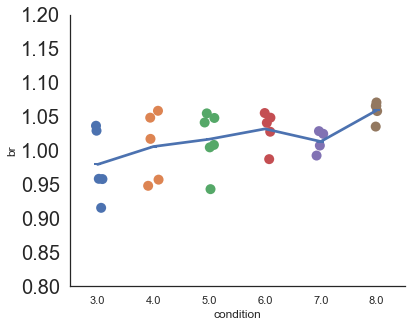

In [79]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import PathCollection
from matplotlib import cm
sns.set(style="white")
    
data_name = 'br'
dic = br_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0.8, 1.2)
plt.show()


In [80]:
from scipy import stats
stats.pearsonr(dic['br'], dic['condition'])

(0.520481039193331, 0.0031924600255140486)

In [82]:
adfn.save_shared_files(Fcode, 'criticality', 'admin')

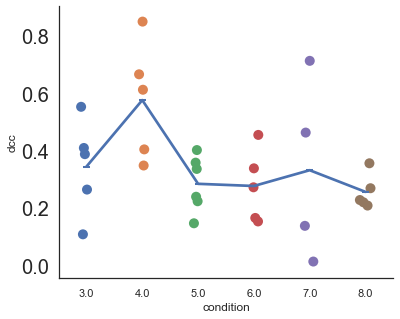

In [86]:
import seaborn as sns
data_name = 'dcc'
dic = dcc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [72]:
from scipy.stats import f_oneway
dcc_l = [np.array(dic['dcc'][dic['condition'] == i]) for i in np.arange(3,8).astype(float)]

F,p = f_oneway(dcc_l[0], dcc_l[1], dcc_l[2], dcc_l[3], dcc_l[4])
F,p

(2.2278855662403134, 0.10244655113505509)

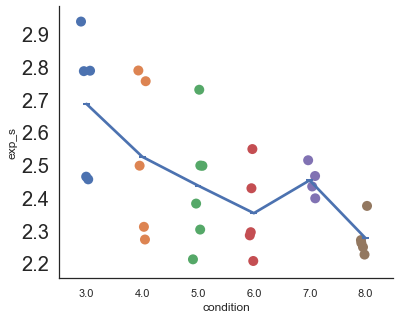

In [457]:
data_name = 'exp_s'
dic = xs_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [458]:
from scipy import stats
stats.pearsonr(dic['exp_s'], dic['condition'])

(-0.5831903515979924, 0.0007186561331050128)

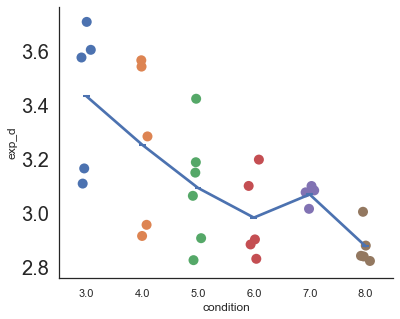

In [459]:
data_name = 'exp_d'
dic = xd_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [88]:
d3 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*3dpf*all*fir*')
d4 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*4dpf*all*fir*')
d5 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*5dpf*all*fir*')
d6 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*6dpf*all*fir*')
d7 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*7dpf*all*fir*')
d8 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*8dpf*all*fir*')
data_ll = d3, d4, d5, d6, d7, d8
data_ll

(['BLNDEV-WILDTYPE-02_2photon_sess-01-3dpf_BLNGR_run-01_all_firing.npy',
  'BLNDEV-WILDTYPE-05_2photon_sess-01-3dpf_BLNGR_run-01_all_firing.npy',
  'BLNDEV-WILDTYPE-06_2photon_sess-01-3dpf_BLNGR_run-01_all_firing.npy',
  'BLNDEV-WILDTYPE-07_2photon_sess-01-3dpf_BLNGR_run-01_all_firing.npy',
  'BLNDEV-WILDTYPE-08_2photon_sess-01-3dpf_BLNGR_run-01_all_firing.npy'],
 ['BLNDEV-WILDTYPE-01_2photon_sess-01-4dpf_BLNGR_run-01_all_firing.npy',
  'BLNDEV-WILDTYPE-02_2photon_sess-01-4dpf_BLNGR_run-01_all_firing.npy',
  'BLNDEV-WILDTYPE-03_2photon_sess-01-4dpf_BLNGR_run-01_all_firing.npy',
  'BLNDEV-WILDTYPE-04_2photon_sess-01-4dpf_BLNGR_run-01_all_firing.npy',
  'BLNDEV-WILDTYPE-05_2photon_sess-01-4dpf_BLNGR_run-01_all_firing.npy'],
 ['BLNDEV-WILDTYPE-01_2photon_sess-01-5dpf_BLNGR_run-01_all_firing.npy',
  'BLNDEV-WILDTYPE-02_2photon_sess-01-5dpf_BLNGR_run-01_all_firing.npy',
  'BLNDEV-WILDTYPE-04_2photon_sess-01-5dpf_BLNGR_run-01_all_firing.npy',
  'BLNDEV-WILDTYPE-06_2photon_sess-01-5dpf_BLNGR_

In [89]:
name_list = ['fr', 'fa', 'fd', 's_corr', 'l_corr', 'dim']
obj, len_list = load(data_ll, name_list)
fr_df = sort('fr', obj)
fa_df = sort('fa', obj)
fd_df = sort('fd', obj)
sc_df = sort('s_corr', obj)
lc_df = sort('l_corr', obj)
dim_df = sort('dim', obj)

0
1
2
3
4
5


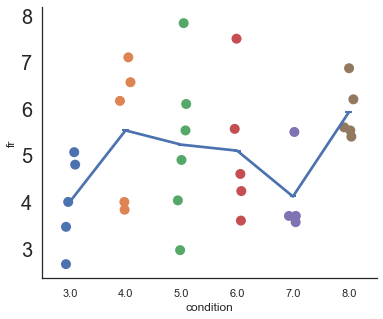

In [90]:
data_name = 'fr'
dic = fr_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [91]:
from scipy import stats
stats.pearsonr(dic['fr'], dic['condition'])

(0.20934802957211907, 0.26687732540846787)

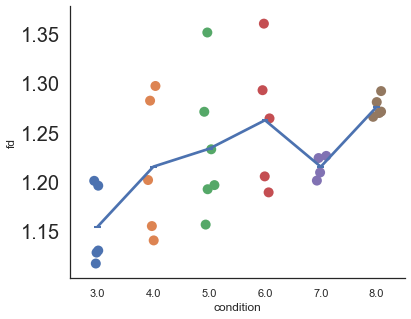

In [92]:
data_name = 'fd'
dic = fd_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [93]:
from scipy import stats
stats.pearsonr(dic['fd'], dic['condition'])

(0.5063440069920478, 0.0043029280225935765)

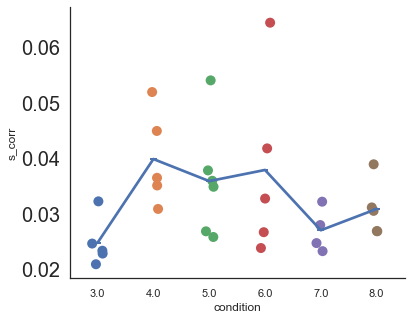

In [508]:
data_name = 's_corr'
dic = sc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

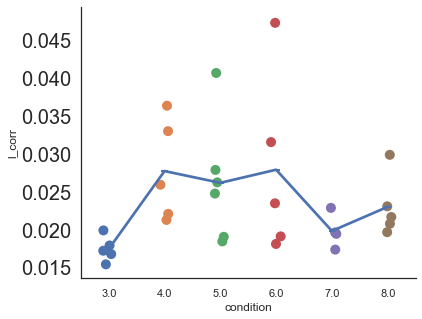

In [509]:
data_name = 'l_corr'
dic = lc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

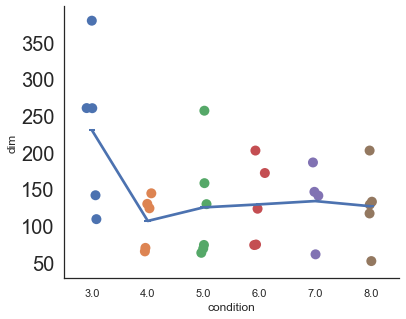

In [510]:
data_name = 'dim'
dic = dim_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Telencephalon

In [102]:
d3 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*3dpf*Tel*crit*')
d4 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*4dpf*Tel*crit*')
d5 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*5dpf*Tel*crit*')
d6 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*6dpf*Tel*crit*')
d7 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*7dpf*Tel*crit*')
d8 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*8dpf*Tel*crit*')
data_ll = d3, d4, d5, d6, d7, d8

In [103]:
for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        print(data['llr_s'], data['llr_d'])

26.260440775285176 96.45430367369984
1590.1064077400897 2671.547082321111
3430.8401222958382 5621.36902936807
944.5283006411819 1640.792394846504
690.6627222423522 1436.793955556359
4018.4792539784103 7817.898266161574
1422.3158152104843 3509.2903261288566
3483.0527234827714 5254.532717186922
6104.759217432751 8592.424130551208
12192.284585629575 16332.897753859506
4812.388578196835 9626.925156777877
6709.693564901216 10895.64868708617
13498.101574124623 18112.14631854115
9917.590820672223 13563.021907323033
3572.956248190225 5541.950015120205
3056.8481850475655 6399.829438348435
13496.02126060499 17332.66213653009
7568.545704277436 11035.394163068951
6145.484917951369 11167.653030802812
6316.52178228226 9257.057188408027
8230.062619678909 13501.415434521401
7987.795446570424 12709.37211978947
4232.427905883975 6940.518231555936
8059.333942937563 13469.778664178277
5853.682254511914 9706.398192427318
9703.770511072333 14432.246352277944
11407.55516349255 16239.439533813056
11715.200040

In [107]:
d3 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*3dpf*allcoord*')
d4 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*4dpf*Tel*crit*')
d5 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*5dpf*Tel*crit*')
d6 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*6dpf*Tel*crit*')
d7 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*7dpf*Tel*crit*')
d8 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*8dpf*Tel*crit*')
d3

['BLNDEV-WILDTYPE-02_2photon_sess-01-3dpf_BLNGR_run-01_allcoord.npy',
 'BLNDEV-WILDTYPE-05_2photon_sess-01-3dpf_BLNGR_run-01_allcoord.npy',
 'BLNDEV-WILDTYPE-06_2photon_sess-01-3dpf_BLNGR_run-01_allcoord.npy',
 'BLNDEV-WILDTYPE-07_2photon_sess-01-3dpf_BLNGR_run-01_allcoord.npy',
 'BLNDEV-WILDTYPE-08_2photon_sess-01-3dpf_BLNGR_run-01_allcoord.npy']

In [48]:
for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        av = data['av']
        
        print(data_ll[i][e])
        print(np.max(av[0]), np.max(av[1])/2.73)

BLNDEV-WILDTYPE-02_2photon_sess-01-3dpf_BLNGR_run-01_Telencephalon_criticality.npy
8 1.465201465201465
BLNDEV-WILDTYPE-05_2photon_sess-01-3dpf_BLNGR_run-01_Telencephalon_criticality.npy
76 6.227106227106227
BLNDEV-WILDTYPE-06_2photon_sess-01-3dpf_BLNGR_run-01_Telencephalon_criticality.npy
728 16.483516483516485
BLNDEV-WILDTYPE-07_2photon_sess-01-3dpf_BLNGR_run-01_Telencephalon_criticality.npy
41 2.197802197802198
BLNDEV-WILDTYPE-08_2photon_sess-01-3dpf_BLNGR_run-01_Telencephalon_criticality.npy
42 3.663003663003663
BLNDEV-WILDTYPE-01_2photon_sess-01-4dpf_BLNGR_run-01_Telencephalon_criticality.npy
128 7.6923076923076925
BLNDEV-WILDTYPE-02_2photon_sess-01-4dpf_BLNGR_run-01_Telencephalon_criticality.npy
67 4.029304029304029
BLNDEV-WILDTYPE-03_2photon_sess-01-4dpf_BLNGR_run-01_Telencephalon_criticality.npy
674 10.256410256410257
BLNDEV-WILDTYPE-04_2photon_sess-01-4dpf_BLNGR_run-01_Telencephalon_criticality.npy
5604 63.36996336996337
BLNDEV-WILDTYPE-05_2photon_sess-01-4dpf_BLNGR_run-01_Tele

In [49]:
name_list = ['br', 'dcc', 'exp_s', 'exp_d']
obj, len_list = load(data_ll, name_list)
br_df = sort('br', obj)
dcc_df = sort('dcc', obj)
xs_df = sort('exp_s', obj)
xd_df = sort('exp_d', obj)

0
1
2
3
4
5


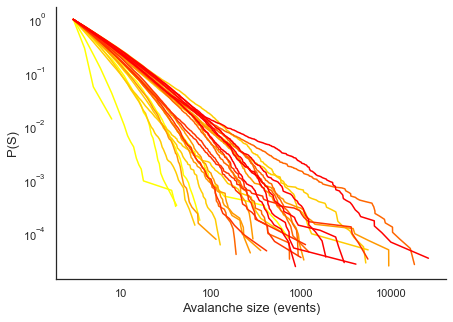

In [96]:
import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.autumn_r(np.linspace(0,1,len(data_ll)))
choose=0

fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        avdistcut = data['av'][choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

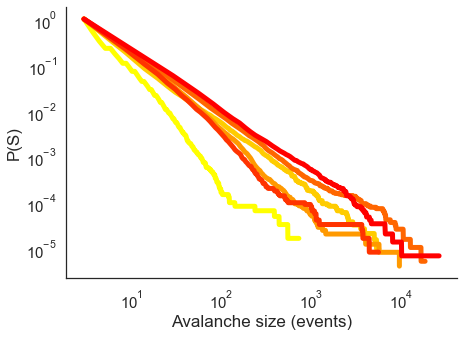

In [97]:
colors  = cm.autumn_r(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    yaxis, xaxis = crfn.mean_av(data_ll[i], 1000, 'size')
    hist = plt.plot(yaxis, xaxis, c = colors[i], linewidth = 5)

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

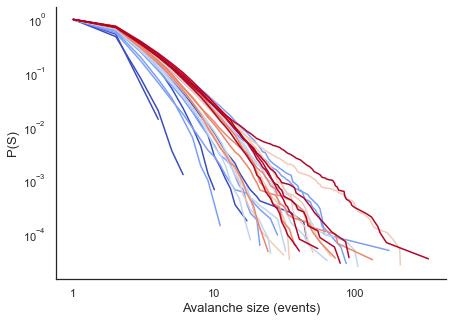

In [516]:
import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=1
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        avdistcut = data['av'][choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

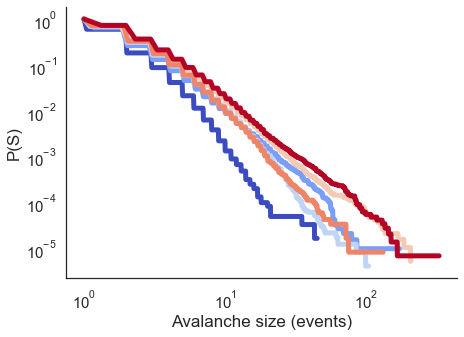

In [517]:
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    yaxis, xaxis = crfn.mean_av(data_ll[i], 1000, 'dur')
    hist = plt.plot(yaxis, xaxis, c = colors[i], linewidth = 5)

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

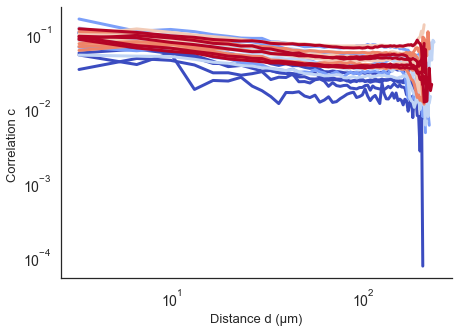

In [539]:
import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=1
fig, axarr = plt.subplots(figsize = (7,5))


for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        yaxis,xaxis = data['corrdis']
        axarr.plot(yaxis,xaxis, '-', linewidth = 3, alpha = 1, color = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_xlabel('Distance d (μm)', size = '13')
axarr.set_ylabel('Correlation c ', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

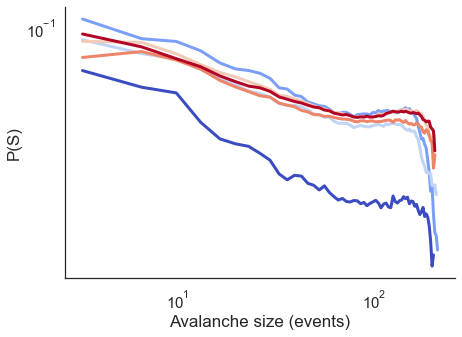

In [538]:
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
fig, axarr = plt.subplots(figsize = (7,5))

for e in range(len(data_ll)):
    
    data_l = data_ll[e]
    mean_y, mean_x = np.mean(np.asarray([np.load(data_l[i], allow_pickle=True).item()['corrdis'] for i in range(len(data_l))]), axis=0)
    yaxis,yaxis = data['corrdis']
    axarr.plot(mean_y,mean_x, '-', linewidth = 3, alpha = 1, color = colors[e])

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

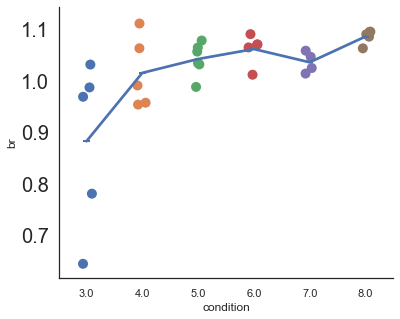

In [518]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import PathCollection
from matplotlib import cm
sns.set(style="white")
    
data_name = 'br'
dic = br_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


In [519]:
from scipy import stats
stats.pearsonr(dic['br'], dic['condition'])

(0.5686963490497587, 0.0010414909941987862)

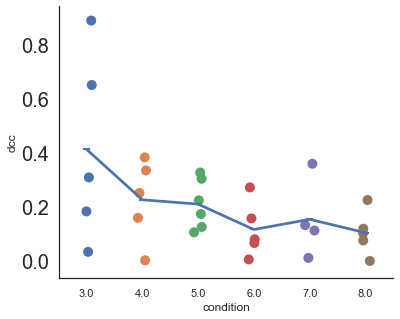

In [520]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.collections import PathCollection
from matplotlib import cm
sns.set(style="white")
    
data_name = 'dcc'
dic = dcc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


In [521]:
from scipy import stats
stats.pearsonr(dic['dcc'], dic['condition'])

(-0.47567884116068637, 0.007888765552627356)

In [88]:
0.05/4

0.0125

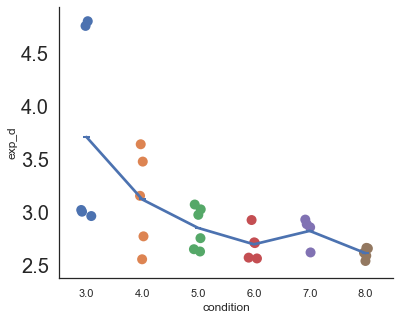

In [356]:
data_name = 'exp_d'
dic = xd_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

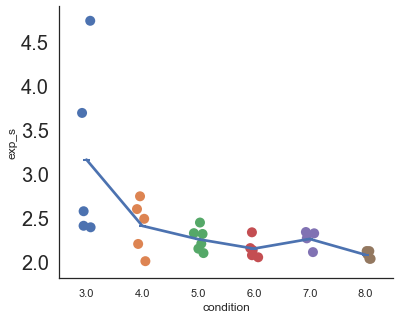

In [523]:
data_name = 'exp_s'
dic = xs_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [87]:
from scipy import stats
stats.pearsonr(dic['exp_s'], dic['condition'])

(-0.3932097162015009, 0.03158490519794871)

In [527]:
d3 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*3dpf*Tel*fir*')
d4 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*4dpf*Tel*fir*')
d5 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*5dpf*Tel*fir*')
d6 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*6dpf*Tel*fir*')
d7 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*7dpf*Tel*fir*')
d8 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*8dpf*Tel*fir*')
data_ll = d3, d4, d5, d6, d7, d8

In [528]:
name_list = ['fr', 'fa', 'fd', 's_corr', 'l_corr', 'dim']
obj, len_list = load(data_ll, name_list)
fr_df = sort('fr', obj)
fa_df = sort('fa', obj)
fd_df = sort('fd', obj)
sc_df = sort('s_corr', obj)
lc_df = sort('l_corr', obj)
dim_df = sort('dim', obj)

0
1
2
3
4
5


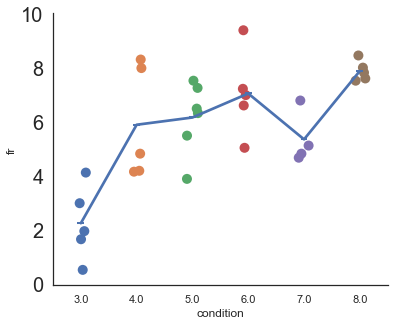

In [529]:
data_name = 'fr'
dic = fr_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

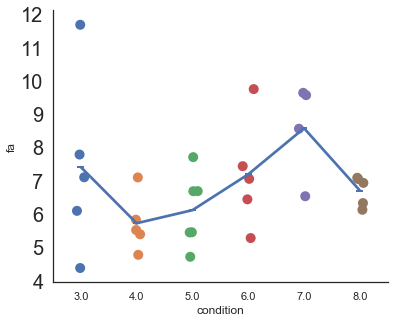

In [530]:
data_name = 'fa'
dic = fa_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

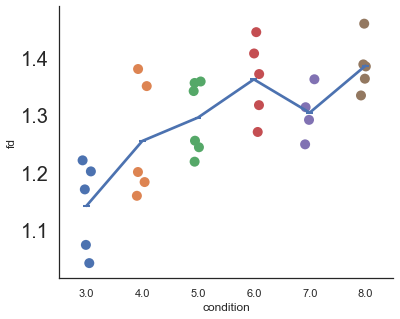

In [531]:
data_name = 'fd'
dic = fd_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

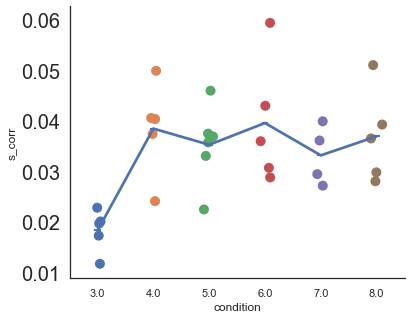

In [532]:
data_name = 's_corr'
dic = sc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

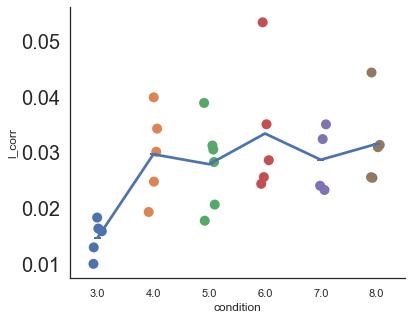

In [533]:
data_name = 'l_corr'
dic = lc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

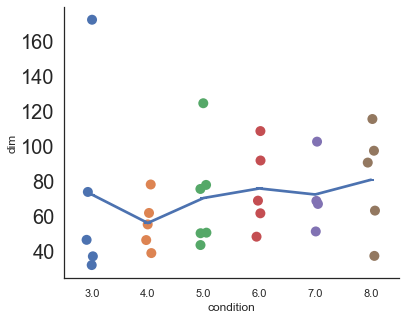

In [534]:
data_name = 'dim'
dic = dim_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Tectum

In [544]:
d3 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*3dpf*Mid*crit*')
d4 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*4dpf*Mid*crit*')
d5 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*5dpf*Mid*crit*')
d6 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*6dpf*Mid*crit*')
d7 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*7dpf*Mid*crit*')
d8 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*8dpf*Mid*crit*')
data_ll = d3, d4, d5, d6, d7, d8

In [545]:
name_list = ['br', 'dcc', 'exp_s', 'exp_d']
obj, len_list = load(data_ll, name_list)
br_df = sort('br', obj)
dcc_df = sort('dcc', obj)
xs_df = sort('exp_s', obj)
xd_df = sort('exp_d', obj)

0
1
2
3
4
5


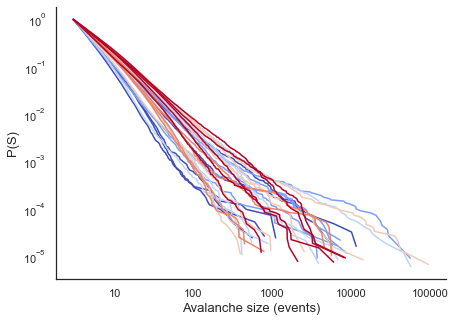

In [546]:
import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        avdistcut = data['av'][choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()


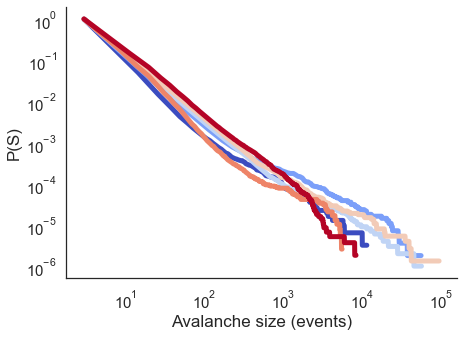

In [547]:
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    yaxis, xaxis = crfn.mean_av(data_ll[i], 1000, 'size')
    hist = plt.plot(yaxis, xaxis, c = colors[i], linewidth = 5)

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

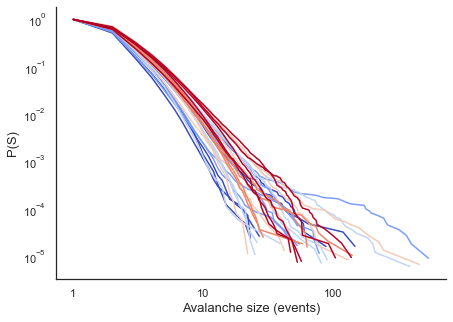

In [548]:
import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=1
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        avdistcut = data['av'][choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()


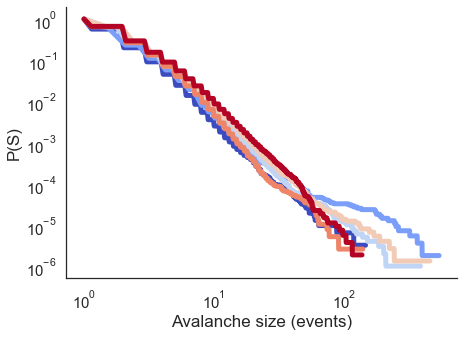

In [549]:
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    yaxis, xaxis = crfn.mean_av(data_ll[i], 1000, 'dur')
    hist = plt.plot(yaxis, xaxis, c = colors[i], linewidth = 5)

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

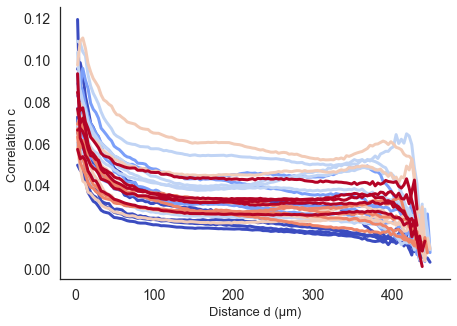

In [555]:
import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=1
fig, axarr = plt.subplots(figsize = (7,5))


for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        yaxis,xaxis = data['corrdis']
        axarr.plot(yaxis,xaxis, '-', linewidth = 3, alpha = 1, color = colors[i])
        
#axarr.set_xscale('log')
#axarr.set_yscale('log')
axarr.set_xlabel('Distance d (μm)', size = '13')
axarr.set_ylabel('Correlation c ', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

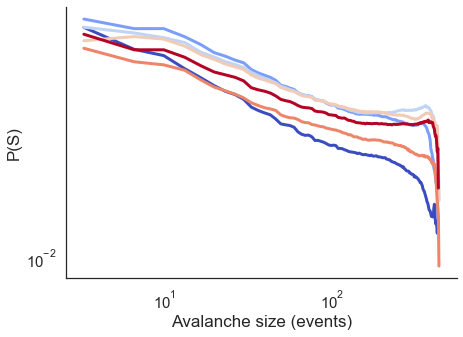

In [556]:

colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
fig, axarr = plt.subplots(figsize = (7,5))

for e in range(len(data_ll)):
    
    data_l = data_ll[e]
    mean_y, mean_x = np.mean(np.asarray([np.load(data_l[i], allow_pickle=True).item()['corrdis'] for i in range(len(data_l))]), axis=0)
    yaxis,yaxis = data['corrdis']
    axarr.plot(mean_y,mean_x, '-', linewidth = 3, alpha = 1, color = colors[e])

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

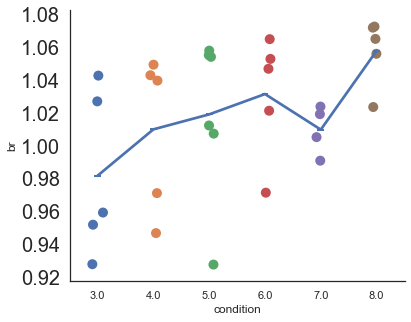

In [550]:
data_name = 'br'
dic = br_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

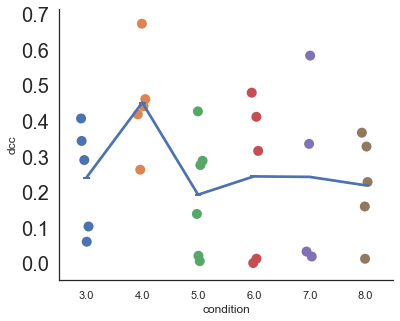

In [551]:
data_name = 'dcc'
dic = dcc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

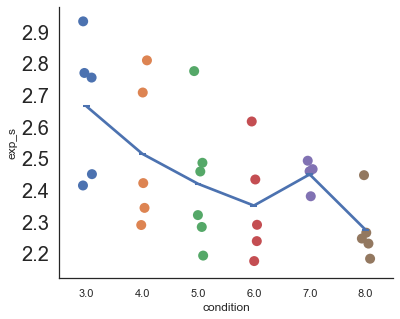

In [552]:
data_name = 'exp_s'
dic = xs_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

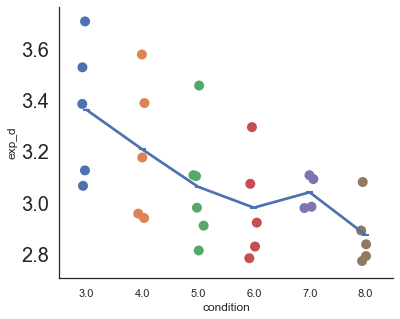

In [553]:
data_name = 'exp_d'
dic = xd_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [557]:
d3 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*3dpf*Mid*fir*')
d4 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*4dpf*Mid*fir*')
d5 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*5dpf*Mid*fir*')
d6 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*6dpf*Mid*fir*')
d7 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*7dpf*Mid*fir*')
d8 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE/', '*8dpf*Mid*fir*')
data_ll = d3, d4, d5, d6, d7, d8
data_ll

(['BLNDEV-WILDTYPE-02_2photon_sess-01-3dpf_BLNGR_run-01_Midbrain_firing.npy',
  'BLNDEV-WILDTYPE-05_2photon_sess-01-3dpf_BLNGR_run-01_Midbrain_firing.npy',
  'BLNDEV-WILDTYPE-06_2photon_sess-01-3dpf_BLNGR_run-01_Midbrain_firing.npy',
  'BLNDEV-WILDTYPE-07_2photon_sess-01-3dpf_BLNGR_run-01_Midbrain_firing.npy',
  'BLNDEV-WILDTYPE-08_2photon_sess-01-3dpf_BLNGR_run-01_Midbrain_firing.npy'],
 ['BLNDEV-WILDTYPE-01_2photon_sess-01-4dpf_BLNGR_run-01_Midbrain_firing.npy',
  'BLNDEV-WILDTYPE-02_2photon_sess-01-4dpf_BLNGR_run-01_Midbrain_firing.npy',
  'BLNDEV-WILDTYPE-03_2photon_sess-01-4dpf_BLNGR_run-01_Midbrain_firing.npy',
  'BLNDEV-WILDTYPE-04_2photon_sess-01-4dpf_BLNGR_run-01_Midbrain_firing.npy',
  'BLNDEV-WILDTYPE-05_2photon_sess-01-4dpf_BLNGR_run-01_Midbrain_firing.npy'],
 ['BLNDEV-WILDTYPE-01_2photon_sess-01-5dpf_BLNGR_run-01_Midbrain_firing.npy',
  'BLNDEV-WILDTYPE-02_2photon_sess-01-5dpf_BLNGR_run-01_Midbrain_firing.npy',
  'BLNDEV-WILDTYPE-04_2photon_sess-01-5dpf_BLNGR_run-01_Midbra

In [558]:
name_list = ['fr', 'fa', 'fd', 's_corr', 'l_corr', 'dim']
obj, len_list = load(data_ll, name_list)
fr_df = sort('fr', obj)
fa_df = sort('fa', obj)
fd_df = sort('fd', obj)
sc_df = sort('s_corr', obj)
lc_df = sort('l_corr', obj)
dim_df = sort('dim', obj)

0
1
2
3
4
5


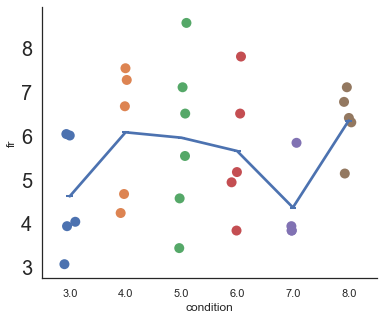

In [559]:
data_name = 'fr'
dic = fr_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

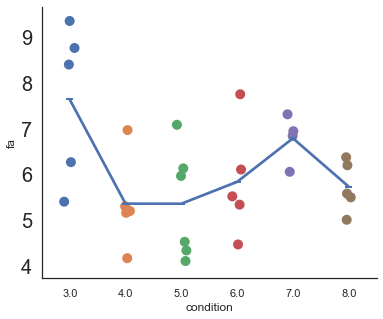

In [560]:
data_name = 'fa'
dic = fa_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

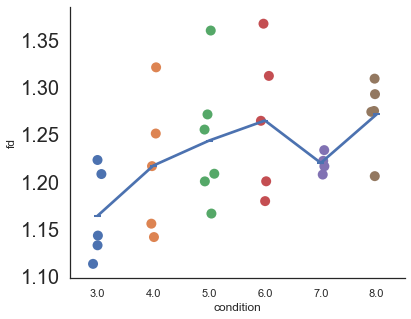

In [561]:
data_name = 'fd'
dic = fd_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

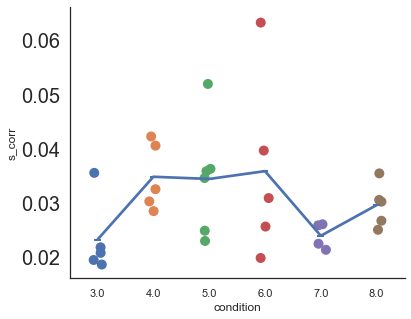

In [562]:
data_name = 's_corr'
dic = sc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

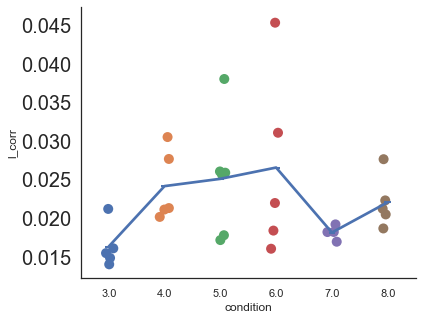

In [563]:
data_name = 'l_corr'
dic = lc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

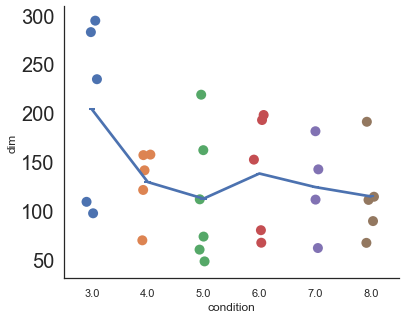

In [564]:
data_name = 'dim'
dic = dim_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Diencephalon

In [567]:
d3 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*3dpf*Di*crit*')
d4 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*4dpf*Di*crit*')
d5 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*5dpf*Di*crit*')
d6 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*6dpf*Di*crit*')
d7 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*7dpf*Di*crit*')
d8 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*8dpf*Di*crit*')
data_ll = d3, d4, d5, d6, d7, d8


In [568]:
name_list = ['br', 'dcc', 'exp_s', 'exp_d']
obj, len_list = load(data_ll, name_list)
br_df = sort('br', obj)
dcc_df = sort('dcc', obj)
xs_df = sort('exp_s', obj)
xd_df = sort('exp_d', obj)

0
1
2
3
4
5


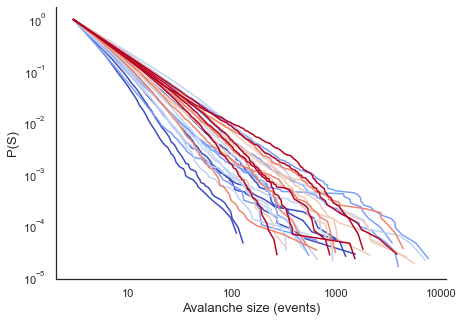

In [569]:

import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        avdistcut = data['av'][choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()


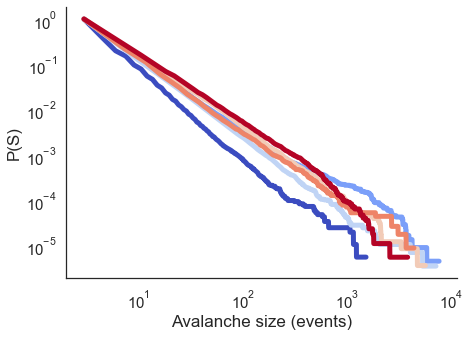

In [570]:
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    yaxis, xaxis = crfn.mean_av(data_ll[i], 1000, 'size')
    hist = plt.plot(yaxis, xaxis, c = colors[i], linewidth = 5)

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

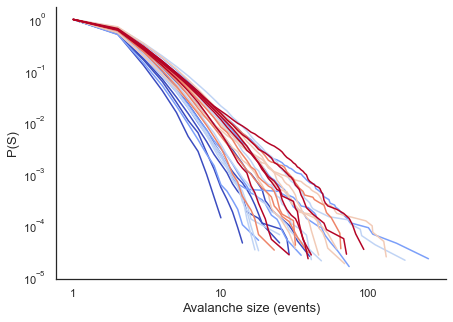

In [571]:

import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=1
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        avdistcut = data['av'][choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()


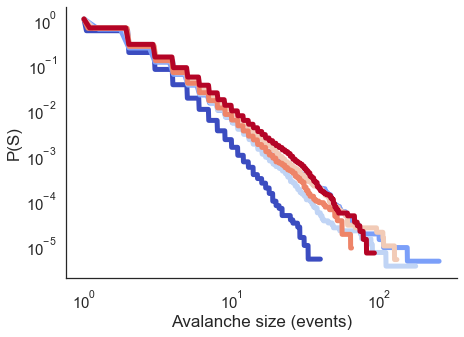

In [573]:
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    yaxis, xaxis = crfn.mean_av(data_ll[i], 1000, 'dur')
    hist = plt.plot(yaxis, xaxis, c = colors[i], linewidth = 5)

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

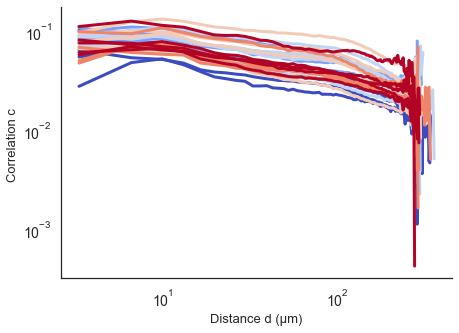

In [575]:
import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=1
fig, axarr = plt.subplots(figsize = (7,5))


for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        yaxis,xaxis = data['corrdis']
        axarr.plot(yaxis,xaxis, '-', linewidth = 3, alpha = 1, color = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_xlabel('Distance d (μm)', size = '13')
axarr.set_ylabel('Correlation c ', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()


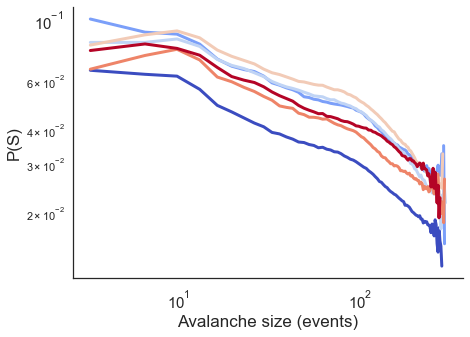

In [576]:
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
fig, axarr = plt.subplots(figsize = (7,5))

for e in range(len(data_ll)):
    
    data_l = data_ll[e]
    mean_y, mean_x = np.mean(np.asarray([np.load(data_l[i], allow_pickle=True).item()['corrdis'] for i in range(len(data_l))]), axis=0)
    yaxis,yaxis = data['corrdis']
    axarr.plot(mean_y,mean_x, '-', linewidth = 3, alpha = 1, color = colors[e])

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

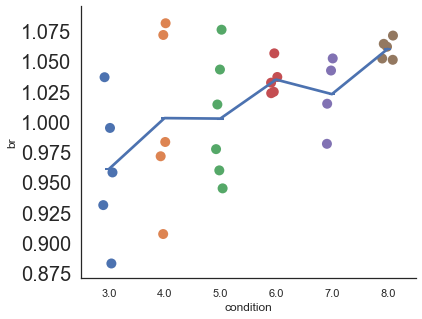

In [577]:
data_name = 'br'
dic = br_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

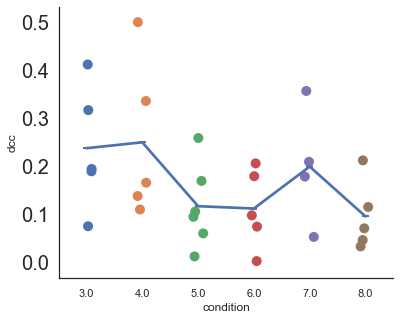

In [578]:
data_name = 'dcc'
dic = dcc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

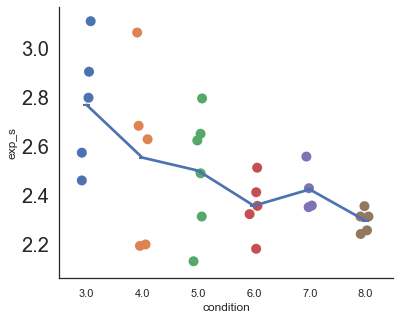

In [579]:
data_name = 'exp_s'
dic = xs_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

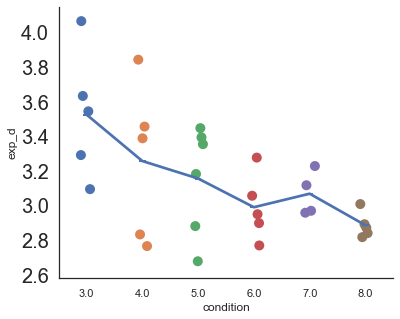

In [581]:
data_name = 'exp_d'
dic = xd_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [584]:
d3 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*3dpf*Di*fir*')
d4 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*4dpf*Di*fir*')
d5 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*5dpf*Di*fir*')
d6 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*6dpf*Di*fir*')
d7 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*7dpf*Di*fir*')
d8 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*8dpf*Di*fir*')
data_ll = d3, d4, d5, d6, d7, d8

In [585]:
name_list = ['fr', 'fa', 'fd', 's_corr', 'l_corr', 'dim']
obj, len_list = load(data_ll, name_list)
fr_df = sort('fr', obj)
fa_df = sort('fa', obj)
fd_df = sort('fd', obj)
sc_df = sort('s_corr', obj)
lc_df = sort('l_corr', obj)
dim_df = sort('dim', obj)

0
1
2
3
4
5


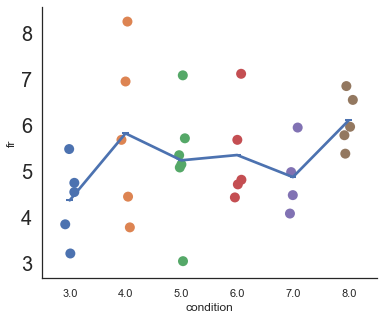

In [587]:
data_name = 'fr'
dic = fr_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

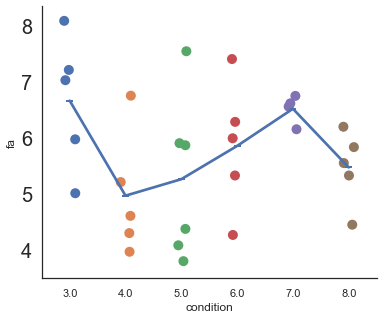

In [589]:
data_name = 'fa'
dic = fa_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

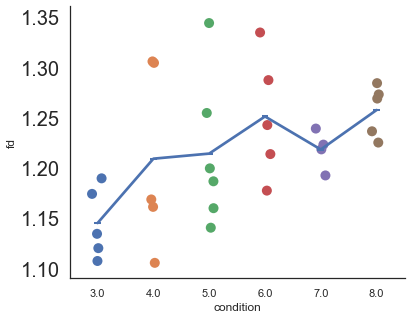

In [590]:
data_name = 'fd'
dic = fd_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

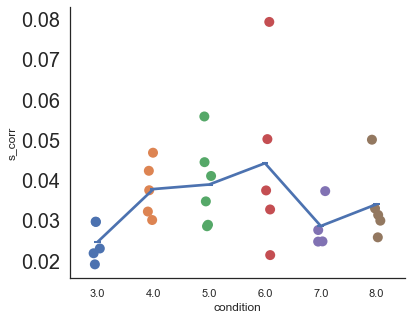

In [591]:
data_name = 's_corr'
dic = sc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

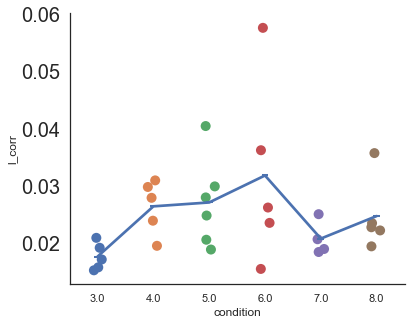

In [592]:
data_name = 'l_corr'
dic = lc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

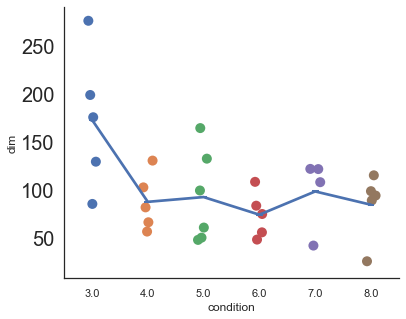

In [593]:
data_name = 'dim'
dic = dim_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Hindbrain

In [596]:
d3 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*3dpf*Hi*crit*')
d4 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*4dpf*Hi*crit*')
d5 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*5dpf*Hi*crit*')
d6 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*6dpf*Hi*crit*')
d7 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*7dpf*Hi*crit*')
d8 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*8dpf*Hi*crit*')
data_ll = d3, d4, d5, d6, d7, d8

In [597]:
name_list = ['br', 'dcc', 'exp_s', 'exp_d']
obj, len_list = load(data_ll, name_list)
br_df = sort('br', obj)
dcc_df = sort('dcc', obj)
xs_df = sort('exp_s', obj)
xd_df = sort('exp_d', obj)

0
1
2
3
4
5


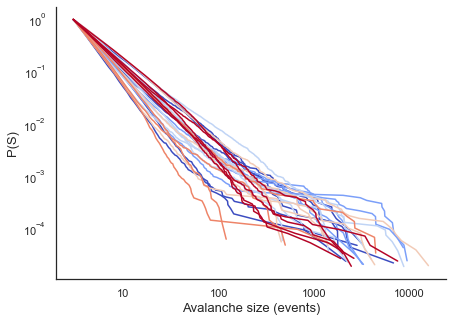

In [600]:

import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        avdistcut = data['av'][choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()


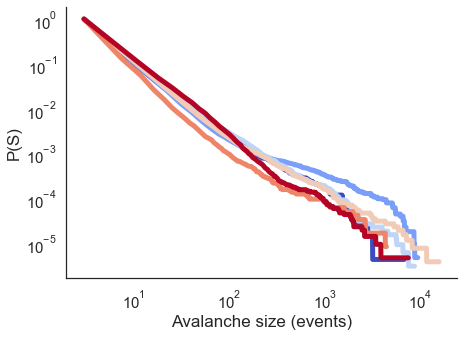

In [601]:
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    yaxis, xaxis = crfn.mean_av(data_ll[i], 1000, 'size')
    hist = plt.plot(yaxis, xaxis, c = colors[i], linewidth = 5)

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

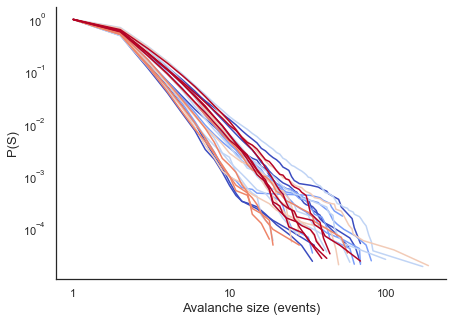

In [598]:

import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=1
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        avdistcut = data['av'][choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()


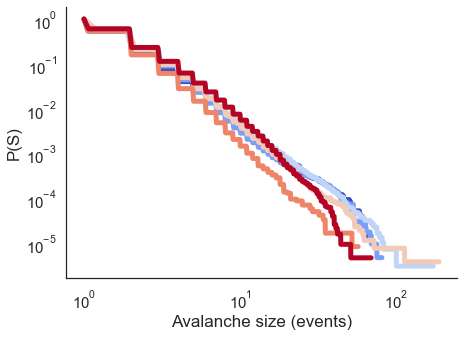

In [599]:
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(data_ll)):
    yaxis, xaxis = crfn.mean_av(data_ll[i], 1000, 'dur')
    hist = plt.plot(yaxis, xaxis, c = colors[i], linewidth = 5)

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

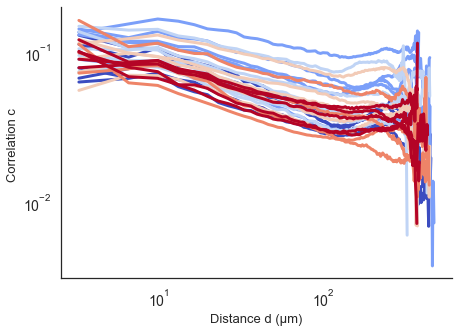

In [605]:

import matplotlib
from matplotlib import cm
import powerlaw
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
choose=1
fig, axarr = plt.subplots(figsize = (7,5))


for i in range(len(data_ll)):
    for e in range(len(data_ll[i])):
        data = np.load(data_ll[i][e], allow_pickle=True).item()
        yaxis,xaxis = data['corrdis']
        axarr.plot(yaxis,xaxis, '-', linewidth = 3, alpha = 1, color = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_xlabel('Distance d (μm)', size = '13')
axarr.set_ylabel('Correlation c ', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

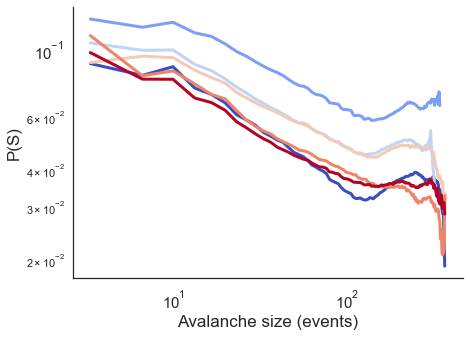

In [606]:
colors  = cm.coolwarm(np.linspace(0,1,len(data_ll)))
fig, axarr = plt.subplots(figsize = (7,5))

for e in range(len(data_ll)):
    
    data_l = data_ll[e]
    mean_y, mean_x = np.mean(np.asarray([np.load(data_l[i], allow_pickle=True).item()['corrdis'] for i in range(len(data_l))]), axis=0)
    yaxis,yaxis = data['corrdis']
    axarr.plot(mean_y,mean_x, '-', linewidth = 3, alpha = 1, color = colors[e])

axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.set_ylabel('P(S)', size = '17')
axarr.set_xlabel('Avalanche size (events)', size = '17')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.yticks(size = 15)
plt.xticks(size = 15)
#plt.savefig(Ffig + 'avsize_ptz_mean.svg', transparent = True)
plt.show()

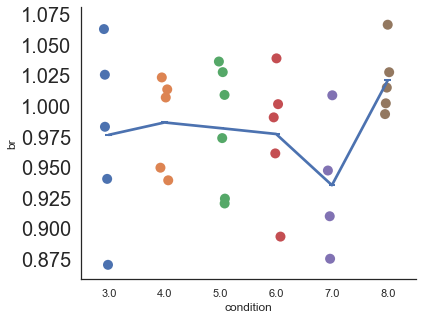

In [603]:
data_name = 'br'
dic = br_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

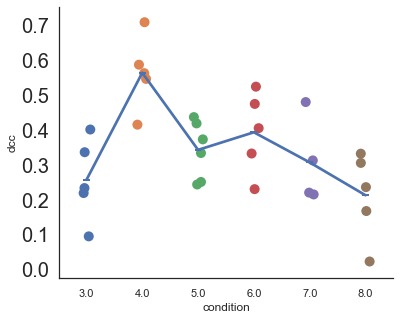

In [610]:
data_name = 'dcc'
dic = dcc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

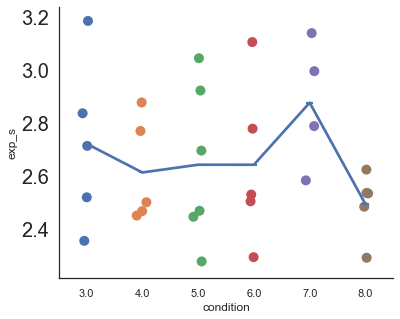

In [608]:
data_name = 'exp_s'
dic = xs_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

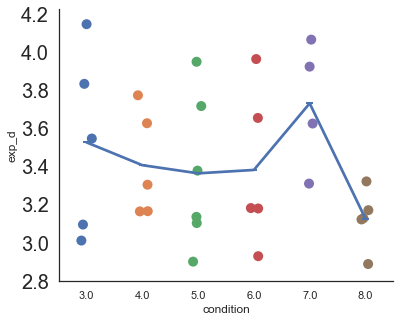

In [609]:
data_name = 'exp_d'
dic = xd_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [611]:
d3 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*3dpf*Hin*fir*')
d4 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*4dpf*Hin*fir*')
d5 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*5dpf*Hin*fir*')
d6 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*6dpf*Hin*fir*')
d7 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*7dpf*Hin*fir*')
d8 = adfn.return_files(Fdata, 'BLNDEV-WILDTYPE', '*8dpf*Hin*fir*')
data_ll = d3, d4, d5, d6, d7, d8



In [612]:
name_list = ['fr', 'fa', 'fd', 's_corr', 'l_corr', 'dim']
obj, len_list = load(data_ll, name_list)
fr_df = sort('fr', obj)
fa_df = sort('fa', obj)
fd_df = sort('fd', obj)
sc_df = sort('s_corr', obj)
lc_df = sort('l_corr', obj)
dim_df = sort('dim', obj)

0
1
2
3
4
5


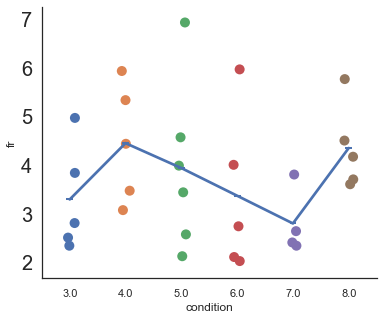

In [613]:
data_name = 'fr'
dic = fr_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

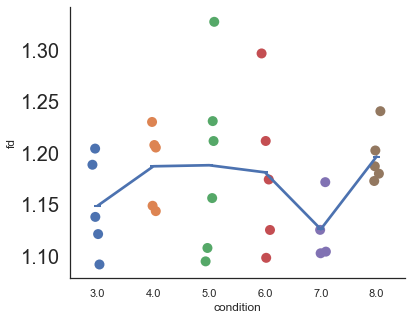

In [614]:
data_name = 'fd'
dic = fd_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

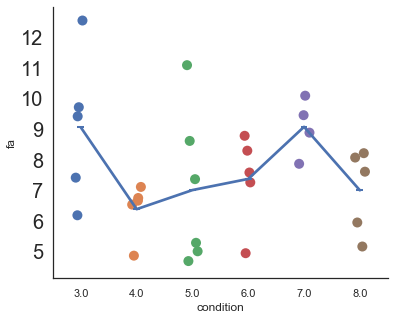

In [615]:
data_name = 'fa'
dic = fa_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

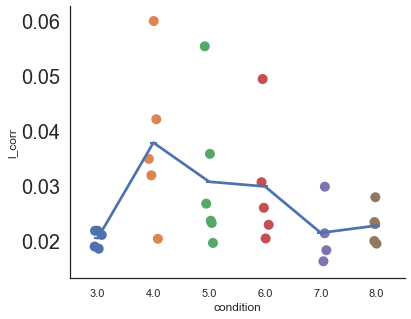

In [616]:
data_name = 'l_corr'
dic = lc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

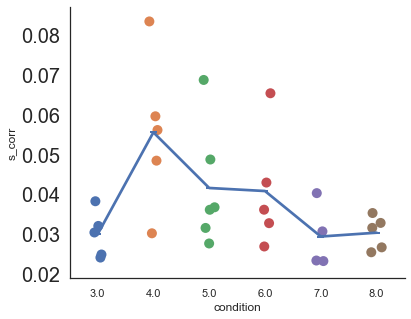

In [617]:
data_name = 's_corr'
dic = sc_df

fig, ax = plt.subplots(figsize = (6,5))
ax = sns.pointplot(x="condition", y=data_name, data = dic, join=True, ci=0, scale=1, markers = '_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="condition", y=data_name, data = dic,size = 10, jitter = True ,alpha = 1)

plt.yticks(size = 20)
points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Tectal data

In [51]:
# Create datalists
#---------------------------------------------------------------------------
experiment = 'TECTUMSPONT-WILDTYPE'
savepath = F10t + 'Project/' + experiment + os.sep 
os.chdir(F10t + 'Project/' + experiment)
NR_3_bin = sorted(glob.glob('*NR*3dpf*spikes.dat*')) 
NR_5_bin = sorted(glob.glob('*NR*5dpf*spikes.dat*')) 
NR_7_bin = sorted(glob.glob('*NR*7dpf*spikes.dat*')) 

GR_3_bin = sorted(glob.glob('*GR*3dpf*spikes.dat*')) 
GR_5_bin = sorted(glob.glob('*GR*5dpf*spikes.dat*')) 
GR_7_bin = sorted(glob.glob('*GR*7dpf*spikes.dat*')) 

NR_3_coord = sorted(glob.glob('*NR*3dpf*cent*')) 
NR_5_coord = sorted(glob.glob('*NR*5dpf*cent*')) 
NR_7_coord = sorted(glob.glob('*NR*7dpf*cent*')) 

GR_3_coord = sorted(glob.glob('*GR*3dpf*cent*')) 
GR_5_coord = sorted(glob.glob('*GR*5dpf*cent*')) 
GR_7_coord = sorted(glob.glob('*GR*7dpf*cent*')) 

bin_list = NR_3_bin, NR_5_bin, NR_7_bin, GR_3_bin, GR_5_bin, GR_7_bin
coord_list = NR_3_coord, NR_5_coord, NR_7_coord, GR_3_coord, GR_5_coord, GR_7_coord

In [ ]:
#nnb
#-------
for i in range(len(coord_list)):
    for e in range(len(coord_list[i])):
        coord = np.loadtxt(coord_list[i][e])
        nnb = crfn.neighbour_new(coord, 50, [.8, .8, 5])
        np.save(savepath + coord_list[i][e][:coord_list[i][e].find('all_cells')+10] + 'nnb.npy', nnb)
        print('Done ' + coord_list[i][e])

In [71]:
# Create datalists
#---------------------------------------------------------------------------
experiment = 'TECTUMSPONT-WILDTYPE'
savepath = F10t + 'Project/' + experiment + os.sep 
os.chdir(F10t + 'Project/' + experiment)
NR_3_nnb = sorted(glob.glob('*NR*3dpf*nnb*')) 
NR_5_nnb = sorted(glob.glob('*NR*5dpf*nnb*')) 
NR_7_nnb = sorted(glob.glob('*NR*7dpf*nnb*')) 

GR_3_nnb = sorted(glob.glob('*GR*3dpf*nnb*')) 
GR_5_nnb = sorted(glob.glob('*GR*5dpf*nnb*')) 
GR_7_nnb = sorted(glob.glob('*GR*7dpf*nnb*')) 
nnb_list = NR_3_nnb, NR_5_nnb, NR_7_nnb, GR_3_nnb, GR_5_nnb, GR_7_nnb

In [90]:
# Create datalists
#---------------------------------------------------------------------------
experiment = 'TECTUMSPONT-WILDTYPE'
savepath = F10t + 'Project/' + experiment + os.sep 
os.chdir(F10t + 'Project/' + experiment)
NR_3_pkg = sorted(glob.glob('*NR*3dpf*pkg*')) 
NR_5_pkg = sorted(glob.glob('*NR*5dpf*pkg*')) 
NR_7_pkg = sorted(glob.glob('*NR*7dpf*pkg*')) 

GR_3_pkg = sorted(glob.glob('*GR*3dpf*pkg*')) 
GR_5_pkg = sorted(glob.glob('*GR*5dpf*pkg*')) 
GR_7_pkg = sorted(glob.glob('*GR*7dpf*pkg*')) 
NR_3_av = sorted(glob.glob('*NR*3dpf*av*')) 
NR_5_av = sorted(glob.glob('*NR*5dpf*av*')) 
NR_7_av = sorted(glob.glob('*NR*7dpf*av*')) 

GR_3_av = sorted(glob.glob('*GR*3dpf*av*')) 
GR_5_av = sorted(glob.glob('*GR*5dpf*av*')) 
GR_7_av = sorted(glob.glob('*GR*7dpf*av*')) 
NR_list = NR_3_av, NR_5_av, NR_7_av
GR_list = GR_3_av, GR_5_av, GR_7_av
NR_list, GR_list

((['180209_WT_NR_h2b_gc6s_3dpf_f1_sa_aligned_all_cells_av.npy',
   '180219_WT_NR_h2b_gc6s_3dpf_f2_sa_aligned_all_cells_av.npy',
   '180219_WT_NR_h2b_gc6s_3dpf_f4_sa_aligned_all_cells_av.npy',
   '180319_WT_NR_h2b_gc6s_3dpf_f2_sa_aligned_all_cells_av.npy',
   '180625_WT_NR_h2b_gc6s_3dpf_f1_sa_aligned_all_cells_av.npy',
   '180625_WT_NR_h2b_gc6s_3dpf_f3_sa_aligned_all_cells_av.npy'],
  ['180129_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_av.npy',
   '180129_WT_NR_h2b_gc6s_5dpf_f3_sa_aligned_all_cells_av.npy',
   '180321_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_av.npy',
   '180321_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_av.npy',
   '180328_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_av.npy',
   '180717_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_av.npy',
   '180717_WT_NR_h2b_gc6s_5dpf_f3_sa_aligned_all_cells_av.npy',
   '180718_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_av.npy'],
  ['180220_WT_NR_h2b_gc6s_7dpf_f1_sa_aligned_all_cells_av.npy',
   '180220_WT_NR_h2b_gc6s_7dpf_f2_sa_a

In [ ]:
#av calculation
#----------------
for i in range(len(nnb_list)):
    for e in range(len(nnb_list[i])):
        nnb = np.load(nnb_list[i][e])
        bind = np.loadtxt(bin_list[i][e])
        av,pkg = crfn.avalanche_r(nnb, bind)
        np.save(savepath + nnb_list[i][e][:nnb_list[i][e].find('all_cells')+10] + 'av.npy', av)
        np.save(savepath + nnb_list[i][e][:nnb_list[i][e].find('all_cells')+10] + 'pkg.npy', pkg)
        print('Done ' + nnb_list[i][e])

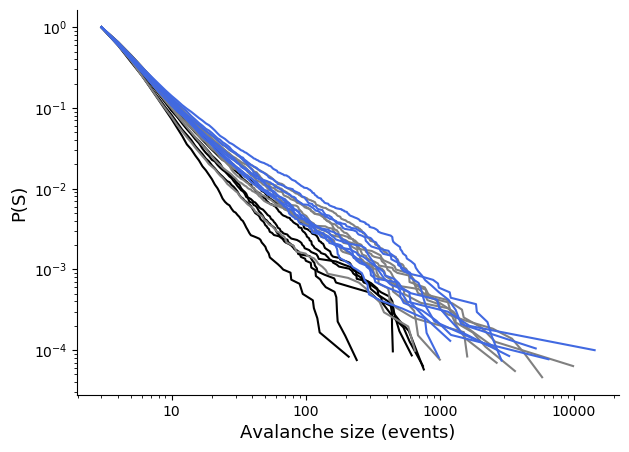

In [107]:
import matplotlib
import powerlaw
num1 = adfn.name_zero('front',2,12,1)
colors = ['black', 'grey','royalblue']
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(NR_list)):
    for e in range(len(NR_list[i])):
        avdistcut = np.load(NR_list[i][e])[choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

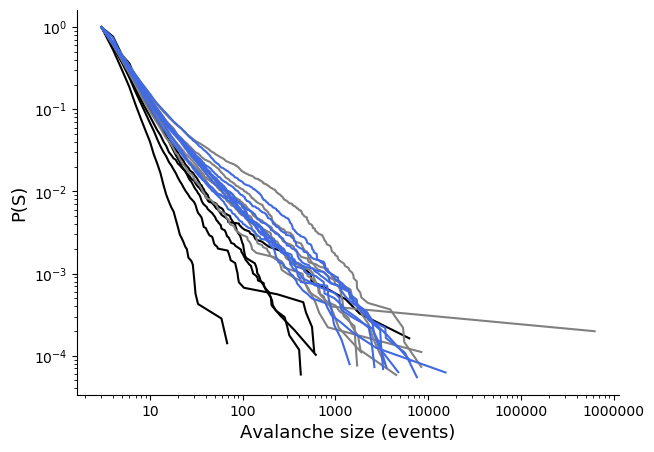

In [108]:
import matplotlib
import powerlaw
num1 = adfn.name_zero('front',2,12,1)
colors = ['black', 'grey','royalblue']
choose=0
fig, axarr = plt.subplots(figsize = (7,5))

for i in range(len(GR_list)):
    for e in range(len(GR_list[i])):
        avdistcut = np.load(GR_list[i][e])[choose]
        powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = colors[i])
        
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

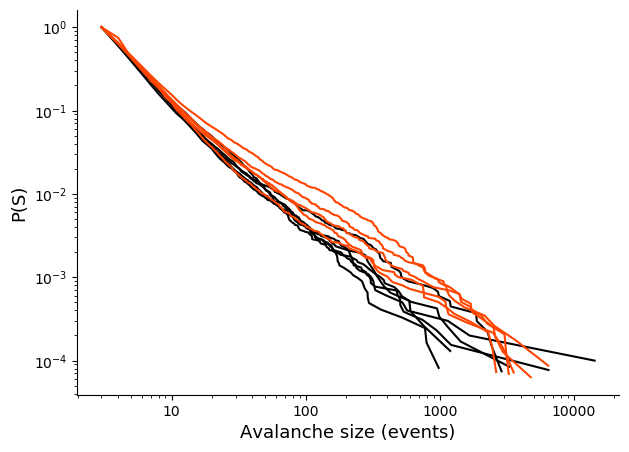

In [120]:
#3dpf comparison

import matplotlib
import powerlaw
num1 = adfn.name_zero('front',2,12,1)
choose=0
index = 0
fig, axarr = plt.subplots(figsize = (7,5))


for e in range(len(NR_list[index])):
    avdistcut = np.load(NR_list[i][e])[choose]
    powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = 'black')

for e in range(len(GR_list[index])):
    avdistcut = np.load(GR_list[i][e])[choose]
    powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = 'orangered')

axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

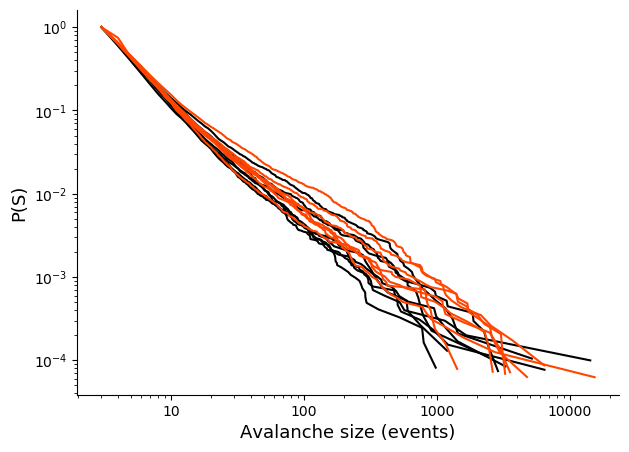

In [119]:
#5dpf comparison

import matplotlib
import powerlaw
num1 = adfn.name_zero('front',2,12,1)
choose=0
index = 1
fig, axarr = plt.subplots(figsize = (7,5))


for e in range(len(NR_list[index])):
    avdistcut = np.load(NR_list[i][e])[choose]
    powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = 'black')

for e in range(len(GR_list[index])):
    avdistcut = np.load(GR_list[i][e])[choose]
    powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = 'orangered')

axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

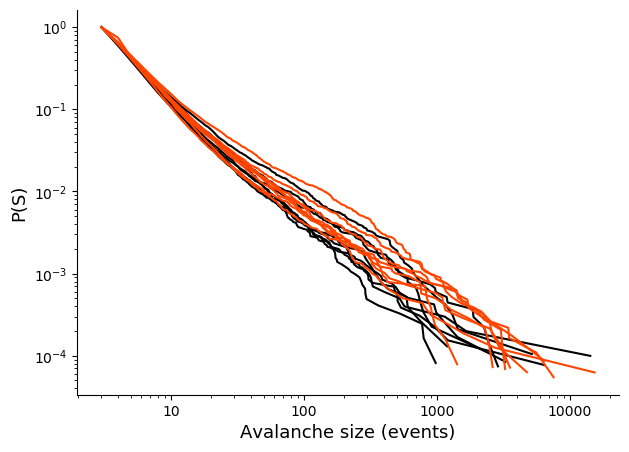

In [118]:
#7dpf comparison

import matplotlib
import powerlaw
num1 = adfn.name_zero('front',2,12,1)
choose=0
index = 2
fig, axarr = plt.subplots(figsize = (7,5))


for e in range(len(NR_list[index])):
    avdistcut = np.load(NR_list[i][e])[choose]
    powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = 'black')

for e in range(len(GR_list[index])):
    avdistcut = np.load(GR_list[i][e])[choose]
    powerlaw.plot_ccdf(avdistcut, markersize = 1, alpha = 1, c = 'orangered')

axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.xlim(right = 1000000)  
#plt.ylim(bottom = 0.000005)  
#axarr.set_title(str(blnlist[0]), size = '13')
axarr.set_ylabel('P(S)', size = '13')
axarr.set_xlabel('Avalanche size (events)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [179]:
np.load(av_list[i][e])

array([[245,   4,  32, ...,   8,   5,   3],
       [ 13,   2,   7, ...,   3,   2,   1]])

In [181]:
for i in range(len(av_list)):
    for e in range(len(av_list[i])):
        curr_av = np.load(av_list[i][e])
        dcc = crfn.DCC(curr_av)
        np.save(savepath + av_list[i][e][:av_list[i][e].find('all_cells')+10] + 'dcc.npy', dcc)
        print('Done ' + av_list[i][e])

Done 180209_WT_NR_h2b_gc6s_3dpf_f1_sa_aligned_all_cells_av.npy
Done 180219_WT_NR_h2b_gc6s_3dpf_f2_sa_aligned_all_cells_av.npy
Done 180219_WT_NR_h2b_gc6s_3dpf_f4_sa_aligned_all_cells_av.npy
Done 180319_WT_NR_h2b_gc6s_3dpf_f2_sa_aligned_all_cells_av.npy
Done 180625_WT_NR_h2b_gc6s_3dpf_f1_sa_aligned_all_cells_av.npy
Done 180625_WT_NR_h2b_gc6s_3dpf_f3_sa_aligned_all_cells_av.npy
Done 180129_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_av.npy
Done 180129_WT_NR_h2b_gc6s_5dpf_f3_sa_aligned_all_cells_av.npy
Done 180321_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_av.npy
Done 180321_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_av.npy
Done 180328_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_av.npy
Done 180717_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_av.npy
Done 180717_WT_NR_h2b_gc6s_5dpf_f3_sa_aligned_all_cells_av.npy
Done 180718_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_av.npy
Done 180220_WT_NR_h2b_gc6s_7dpf_f1_sa_aligned_all_cells_av.npy
Done 180220_WT_NR_h2b_gc6s_7dpf_f2_sa_aligned_all_cells

In [182]:
# Create datalists
#---------------------------------------------------------------------------
experiment = 'TECTUMSPONT-WILDTYPE'
savepath = F10t + 'Project/' + experiment + os.sep 
os.chdir(F10t + 'Project/' + experiment)
NR_3_dcc = sorted(glob.glob('*NR*3dpf*dcc*')) 
NR_5_dcc = sorted(glob.glob('*NR*5dpf*dcc*')) 
NR_7_dcc = sorted(glob.glob('*NR*7dpf*dcc*')) 

GR_3_dcc = sorted(glob.glob('*GR*3dpf*dcc*')) 
GR_5_dcc = sorted(glob.glob('*GR*5dpf*dcc*')) 
GR_7_dcc = sorted(glob.glob('*GR*7dpf*dcc*')) 

NR_list = NR_3_dcc, NR_5_dcc, NR_7_dcc
GR_list = GR_3_dcc, GR_5_dcc, GR_7_dcc
NR_list, GR_list

((['180209_WT_NR_h2b_gc6s_3dpf_f1_sa_aligned_all_cells_dcc.npy',
   '180219_WT_NR_h2b_gc6s_3dpf_f2_sa_aligned_all_cells_dcc.npy',
   '180219_WT_NR_h2b_gc6s_3dpf_f4_sa_aligned_all_cells_dcc.npy',
   '180319_WT_NR_h2b_gc6s_3dpf_f2_sa_aligned_all_cells_dcc.npy',
   '180625_WT_NR_h2b_gc6s_3dpf_f1_sa_aligned_all_cells_dcc.npy',
   '180625_WT_NR_h2b_gc6s_3dpf_f3_sa_aligned_all_cells_dcc.npy'],
  ['180129_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_dcc.npy',
   '180129_WT_NR_h2b_gc6s_5dpf_f3_sa_aligned_all_cells_dcc.npy',
   '180321_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_dcc.npy',
   '180321_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_dcc.npy',
   '180328_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_dcc.npy',
   '180717_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_dcc.npy',
   '180717_WT_NR_h2b_gc6s_5dpf_f3_sa_aligned_all_cells_dcc.npy',
   '180718_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_dcc.npy'],
  ['180220_WT_NR_h2b_gc6s_7dpf_f1_sa_aligned_all_cells_dcc.npy',
   '180220_WT_NR_h2b_gc

In [196]:
np.load(NR_list[0][0])

array([0.1481087 , 2.82263298, 3.20916077])

In [210]:
#EXP - SIZE
import pandas as pd

exp_s = list(range(42))
age = list(range(42))
cond = list(range(42))

age_list = ['3dpf', '5dpf', '7dpf']
cond_list = ['NR', 'GR']
count=0
e_count = 0
list_list = NR_list, GR_list
for i in range(len(list_list)):
    for x in range(len(list_list[i])):
        for e in range(len(list_list[i][x])):
            exp_s[count] = np.load(list_list[i][x][e])[1]
            age[count] = age_list[x]
            cond[count] = cond_list[e_count]
            count+=1
    e_count+=1
exps_df = pd.DataFrame({"exponent":exp_s , "age":age, "condition": cond})

exp_d = list(range(42))
age = list(range(42))
cond = list(range(42))

age_list = ['3dpf', '5dpf', '7dpf']
cond_list = ['NR', 'GR']
count=0
e_count = 0
list_list = NR_list, GR_list
for i in range(len(list_list)):
    for x in range(len(list_list[i])):
        for e in range(len(list_list[i][x])):
            exp_d[count] = np.load(list_list[i][x][e])[2]
            age[count] = age_list[x]
            cond[count] = cond_list[e_count]
            count+=1
    e_count+=1
expd_df = pd.DataFrame({"exponent":exp_d , "age":age, "condition": cond})


dcc = list(range(42))
age = list(range(42))
cond = list(range(42))

age_list = ['3dpf', '5dpf', '7dpf']
cond_list = ['NR', 'GR']
count=0
e_count = 0
list_list = NR_list, GR_list
for i in range(len(list_list)):
    for x in range(len(list_list[i])):
        for e in range(len(list_list[i][x])):
            dcc[count] = np.load(list_list[i][x][e])[0]
            age[count] = age_list[x]
            cond[count] = cond_list[e_count]
            count+=1
    e_count+=1
dcc_df = pd.DataFrame({"dcc":dcc , "age":age, "condition": cond})

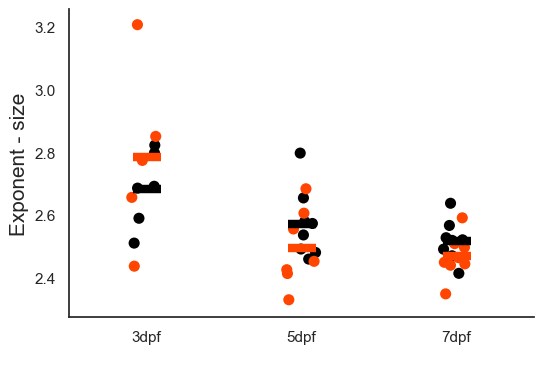

In [203]:
from matplotlib.collections import PathCollection
from matplotlib import cm
sns.set(style="white")
colors1  = cm.Spectral_r(np.linspace(0,1,len(blnlist)))
new_colors = np.vstack((colors1[0],np.vstack((colors1[2:4],colors1[5:]))))
colors = ['black', 'orangered']
fig, ax = plt.subplots(figsize = (6,4))
ax = sns.pointplot(x="age", y="exponent", data = exps_df, hue = 'condition', palette = colors, join=False, ci=2, scale=3, markers='_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="age", y="exponent", data = exps_df, hue = 'condition', palette = colors, size = 8, jitter = True ,alpha = 1)

points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(' ', size = '13')
ax.set_ylabel('Exponent - size', size = '15')
ax.legend_.remove()
#plt.ylim(0.5,1.3)
plt.show()

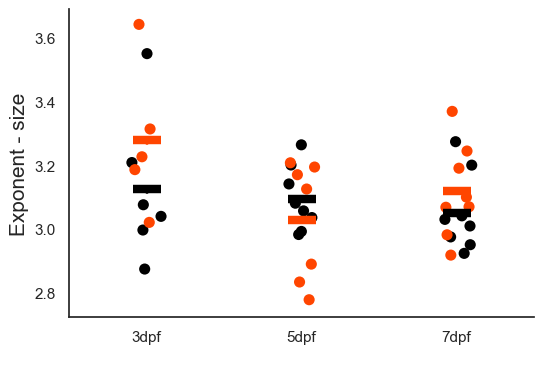

In [209]:
from matplotlib.collections import PathCollection
from matplotlib import cm
sns.set(style="white")
colors1  = cm.Spectral_r(np.linspace(0,1,len(blnlist)))
new_colors = np.vstack((colors1[0],np.vstack((colors1[2:4],colors1[5:]))))
colors = ['black', 'orangered']
fig, ax = plt.subplots(figsize = (6,4))
ax = sns.pointplot(x="age", y="exponent", data = expd_df, hue = 'condition', palette = colors, join=False, ci=2, scale=3, markers='_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="age", y="exponent", data = expd_df, hue = 'condition', palette = colors, size = 8, jitter = True ,alpha = 1)

points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(' ', size = '13')
ax.set_ylabel('Exponent - dur', size = '15')
ax.legend_.remove()
#plt.ylim(0.5,1.3)
plt.show()

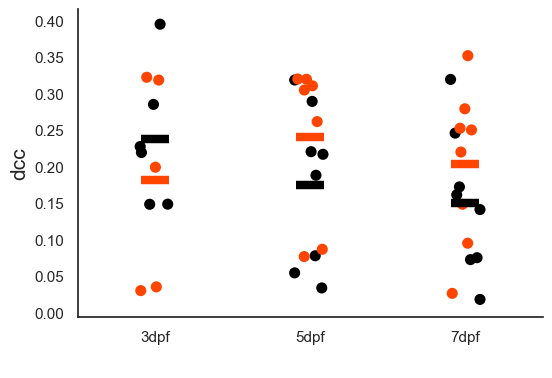

In [213]:
from matplotlib.collections import PathCollection
from matplotlib import cm
sns.set(style="white")
colors1  = cm.Spectral_r(np.linspace(0,1,len(blnlist)))
new_colors = np.vstack((colors1[0],np.vstack((colors1[2:4],colors1[5:]))))
colors = ['black', 'orangered']
fig, ax = plt.subplots(figsize = (6,4))
ax = sns.pointplot(x="age", y="dcc", data = dcc_df, hue = 'condition', palette = colors, join=False, ci=2, scale=3, markers='_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="age", y="dcc", data = dcc_df, hue = 'condition', palette = colors, size = 8, jitter = True ,alpha = 1)

points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(' ', size = '13')
ax.set_ylabel('dcc', size = '15')
ax.legend_.remove()
#plt.ylim(0.5,1.3)
plt.show()

In [ ]:
#BR 
#----------------
for i in range(len(pkg_list)):
    for e in range(len(pkg_list[i])):
        pkg = np.load(pkg_list[i][e])
        av = np.load(av_list[i][e])
        br = crfn.branch(pkg, av)
        np.save(savepath + pkg_list[i][e][:pkg_list[i][e].find('all_cells')+10] + 'br.npy', br)
        print('Done ' + _list[i][e])

In [125]:
# Create datalists
#---------------------------------------------------------------------------
experiment = 'TECTUMSPONT-WILDTYPE'
savepath = F10t + 'Project/' + experiment + os.sep 
os.chdir(F10t + 'Project/' + experiment)
NR_3_br = sorted(glob.glob('*NR*3dpf*br*')) 
NR_5_br = sorted(glob.glob('*NR*5dpf*br*')) 
NR_7_br = sorted(glob.glob('*NR*7dpf*br*')) 

GR_3_br = sorted(glob.glob('*GR*3dpf*br*')) 
GR_5_br = sorted(glob.glob('*GR*5dpf*br*')) 
GR_7_br = sorted(glob.glob('*GR*7dpf*br*')) 

NR_list = NR_3_br, NR_5_br, NR_7_br
GR_list = GR_3_br, GR_5_br, GR_7_br
NR_list, GR_list

((['180209_WT_NR_h2b_gc6s_3dpf_f1_sa_aligned_all_cells_br.npy',
   '180219_WT_NR_h2b_gc6s_3dpf_f2_sa_aligned_all_cells_br.npy',
   '180219_WT_NR_h2b_gc6s_3dpf_f4_sa_aligned_all_cells_br.npy',
   '180319_WT_NR_h2b_gc6s_3dpf_f2_sa_aligned_all_cells_br.npy',
   '180625_WT_NR_h2b_gc6s_3dpf_f1_sa_aligned_all_cells_br.npy',
   '180625_WT_NR_h2b_gc6s_3dpf_f3_sa_aligned_all_cells_br.npy'],
  ['180129_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_br.npy',
   '180129_WT_NR_h2b_gc6s_5dpf_f3_sa_aligned_all_cells_br.npy',
   '180321_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_br.npy',
   '180321_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_br.npy',
   '180328_WT_NR_h2b_gc6s_5dpf_f2_sa_aligned_all_cells_br.npy',
   '180717_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_br.npy',
   '180717_WT_NR_h2b_gc6s_5dpf_f3_sa_aligned_all_cells_br.npy',
   '180718_WT_NR_h2b_gc6s_5dpf_f1_sa_aligned_all_cells_br.npy'],
  ['180220_WT_NR_h2b_gc6s_7dpf_f1_sa_aligned_all_cells_br.npy',
   '180220_WT_NR_h2b_gc6s_7dpf_f2_sa_a

In [158]:
#BRANCH RATIO
import pandas as pd

branch = list(range(42))
age = list(range(42))
cond = list(range(42))

age_list = ['3dpf', '5dpf', '7dpf']
cond_list = ['NR', 'GR']
count=0
e_count = 0
list_list = NR_list, GR_list
for i in range(len(list_list)):
    for x in range(len(list_list[i])):
        for e in range(len(list_list[i][x])):
            branch[count] = np.load(list_list[i][x][e])
            age[count] = age_list[x]
            cond[count] = cond_list[e_count]
            count+=1
    e_count+=1
bdf = pd.DataFrame({"Branching ratio":branch , "age":age, "condition": cond})


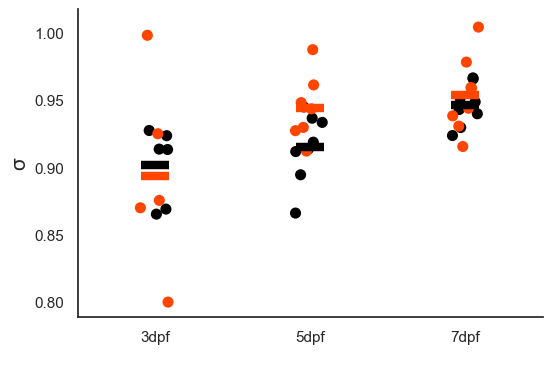

In [176]:
from matplotlib.collections import PathCollection
from matplotlib import cm
sns.set(style="white")
colors1  = cm.Spectral_r(np.linspace(0,1,len(blnlist)))
new_colors = np.vstack((colors1[0],np.vstack((colors1[2:4],colors1[5:]))))
colors = ['black', 'orangered']
fig, ax = plt.subplots(figsize = (6,4))
ax = sns.pointplot(x="age", y="Branching ratio", data = bdf, hue = 'condition', palette = colors, join=False, ci=2, scale=3, markers='_')
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)
ax = sns.stripplot(x="age", y="Branching ratio", data = bdf, hue = 'condition', palette = colors, size = 8, jitter = True ,alpha = 1)

points = ax.collections
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(' ', size = '13')
ax.set_ylabel('σ', size = '15')
ax.legend_.remove()
#plt.ylim(0.5,1.3)
plt.show()